## Efficient Low Noise Neural Network

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from IPython.display import Image
import pprint as pp
import random
import time
import sys
import os
try:
   import cPickle as cPickle
except:
   import pickle as cPickle

### Load data

In [2]:
data = pd.read_csv('dataset/spam.csv', encoding='latin-1')

In [3]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# Drop some unwanted columns that do not provide insight
data_modified = data.loc[:, ~data.columns.str.contains('^Unnamed')]

In [5]:
data_modified = data_modified.rename(columns={"v1":"Label", "v2":"Text"})
data_modified.loc[(data_modified.Label == "spam") , 'Label'] = "SPAM"
data_modified.loc[(data_modified.Label == "ham") , 'Label'] = "HAM"
# Show last 5 in dataset
data_modified.tail(5)

,Label,Text
5567,SPAM,This is the 2nd time we have tried 2 contact u...
5568,HAM,Will Ì_ b going to esplanade fr home?
5569,HAM,"Pity, * was in mood for that. So...any other s..."
5570,HAM,The guy did some bitching but I acted like i'd...
5571,HAM,Rofl. Its true to its name


In [6]:
data_modified.Label.value_counts()

HAM     4825
SPAM     747
Name: Label, dtype: int64

### Data Preparation

Training Data

In [7]:
# first 4500 reviews
training_data = data_modified[4500:4972].reset_index(drop=True)
training_data_length = training_data.shape[0]
training_data.head()

,Label,Text
0,HAM,So wat's da decision?
1,HAM,Wot is u up 2 then bitch?
2,HAM,Stupid.its not possible
3,HAM,She told to hr that he want posting in chennai...
4,SPAM,Mobile Club: Choose any of the top quality ite...


Shape of training data

In [8]:
pp.pprint(training_data.shape)
pp.pprint(training_data.Label.shape)

(472, 2)
(472,)


Validation Data

In [9]:
# middle 972 reviews
validation_data = data_modified[4500:4972].reset_index(drop=True)
validation_data_length = validation_data.shape[0]
validation_data.head()

,Label,Text
0,HAM,So wat's da decision?
1,HAM,Wot is u up 2 then bitch?
2,HAM,Stupid.its not possible
3,HAM,She told to hr that he want posting in chennai...
4,SPAM,Mobile Club: Choose any of the top quality ite...


Shape of validation data

In [10]:
pp.pprint(validation_data.shape)
pp.pprint(validation_data.Label.shape)

(472, 2)
(472,)


Testing data

In [11]:
# last 600 reviews
test_data = data_modified[4972:5572].reset_index(drop=True)
test_data_length = test_data.shape[0]
test_data.head()

,Label,Text
0,HAM,Oops I was in the shower when u called. Hey a ...
1,HAM,Aiyo u so poor thing... Then u dun wan 2 eat? ...
2,HAM,Yar... I tot u knew dis would happen long ago ...
3,HAM,You are gorgeous! keep those pix cumming :) th...
4,HAM,A boy was late 2 home. His father: \POWER OF F...


Shape of Testing data

In [12]:
pp.pprint(test_data.shape)
pp.pprint(test_data.Label.shape)

(600, 2)
(600,)


### Analysing Ineffiencies in Network

#### Pruning

Given the volume of our data, the training speed is still pretty low and have to find ways to increment it. Since, effectively, **0 multiplied by any number is still 0**, we could find a way to disregard inputs that are **0** and only consider those with **1**. 

This will improve our computation time allowing us to train on even more data.

#### Eficient and Low Noise SentimentalNetwork

In [13]:
# Let's tweak our network from before to model these phenomena
class EfficientLowNoiseSpamFilterNeuralNetwork(object):
    def __init__(self, training_data, num_hidden_nodes=10, num_epochs=10, learning_rate=0.1, min_count=10,polar_cutoff=0.1):
        # set our random number generator 
        np.random.seed(1)
        # set our improvement parameters
        self.min_count = min_count
        # ToDo -cater different centers of the frquency ditribution
        self.polar_cutoff = polar_cutoff
        # pre-process data
        self.pre_process_data(training_data)
        
        # set network paramaters
        self.num_features = len(self.vocab)
        self.vocab_vector = np.zeros((1, len(self.vocab)))
        self.num_input_nodes = self.num_features
        self.num_hidden_nodes = num_hidden_nodes
        self.num_epochs = num_epochs
        self.num_output_nodes = 1
        self.learning_rate = learning_rate
        
        # for printing later
        self.losses = {'train':[], 'validation':[]}
        self.accuracy = {'train':[], 'validation':[]}
        self.confusion_matrix = np.zeros((1,4))
        # initialize weights
        self.weights_i_h = np.random.randn(self.num_input_nodes, self.num_hidden_nodes)
        self.weights_h_o = np.random.randn(self.num_hidden_nodes, self.num_output_nodes)
         # initialize weights
        self.bias_i_h = np.zeros(self.num_hidden_nodes)
        self.bias_h_o = np.zeros(self.num_output_nodes)
        # initialise the hidden layer with zeros
        self.hidden_layer = np.zeros((self.num_output_nodes, self.num_hidden_nodes))
        
    def forward_backward_propagate(self, text, label):
        ### Forward pass ###
        # Input Layer & Hidden layer operation
        self.hidden_layer *= 0
        for index in text:
            self.hidden_layer += self.weights_i_h[index]
        self.hidden_layer += self.bias_i_h
            
        # Output layer
        output_layer = self.sigmoid(self.hidden_layer.dot(self.weights_h_o) + self.bias_h_o)
        
        ### Backward pass ###
        # Output error
        output_layer_error = output_layer - self.get_target_for_label(label)
        output_layer_delta = output_layer_error * self.sigmoid_derivative(output_layer)

        # Backpropagated error - to the hidden layer
        hidden_layer_error = output_layer_delta.dot(self.weights_h_o.T)
        # hidden layer gradients - no nonlinearity so it's the same as the error
        hidden_layer_delta = output_layer_error 

        # update the weights and bias - with grdient descent
        self.weights_h_o -= self.hidden_layer.T.dot(output_layer_delta) * self.learning_rate 
        self.bias_h_o -= output_layer_delta[0] * self.learning_rate 
        # update only the weights and bias used in the forward pass
        for index in text:
            self.weights_i_h[index] -= hidden_layer_delta[0] * self.learning_rate
        self.bias_i_h -= hidden_layer_delta[0] * self.learning_rate
        
        if(output_layer >= 0.5 and self.get_target_for_label(label) == 1):
                self.correct_so_far += 1
        elif(output_layer < 0.5 and self.get_target_for_label(label) == 0):
                self.correct_so_far += 1
        
    def train(self):
        # process data to eliminate zero's
        training_data_text = list()
        for review in training_data.Text:
            indices = set()
            for word in review.split(" "):
                if(word in self.word_to_column.keys()):
                    indices.add(self.word_to_column[word])
            training_data_text.append(list(indices))
        
        # iterate through all epochs
        for epoch in range(self.num_epochs):
            self.correct_so_far = 0
            start = time.time()
            training_loss = 0
            validation_loss = 0
            training_accuracy = 0

            # train over all rows of training data
            for row in range(training_data.shape[0]):
                # Forward and Back Propagation
                self.forward_backward_propagate(training_data_text[row], training_data.Label[row])
                # calculate our speed
                elasped_time = float(time.time() - start + 0.001)
                samples_per_second = row / float(elasped_time)
                # calculate our accuracy
                training_accuracy = self.correct_so_far * 100 / float(row+1)
                # print progress of training
                sys.stdout.write("\rEpoch: "+ str(epoch)
                                 + " Progress: " + str(100 * row/float(training_data.shape[0]))[:4] + "%"
                                 + " Speed(samples/sec): " + str(samples_per_second)[0:5] 
                                 + " #Correct: " + str(self.correct_so_far) 
                                 + " #Trained: " + str(row+1) 
                                 + " Training Accuracy: " + str(training_accuracy)[:4] + "%")
            
            self.accuracy["train"].append(training_accuracy) 
                
            training_loss = self.run(training_data[0:7000])
            validation_loss = self.run(validation_data,  mode="validate")
            self.losses["train"].append(training_loss)
            self.losses["validation"].append(validation_loss)      
            print("")
            
    def run(self, input_data, mode="train"):
        # total losses for sample
        val_correct_so_far = 0
        val_accuracy = 0
        loss = 0
        # iterate through all training samples
        for row in range(0, input_data.shape[0]):
            # get prediction
            pred = self.predict(input_data.Text[row])
            # calculate the loss
            loss += np.mean((pred - self.get_target_for_label(input_data.Label[row]))**2)
            # Calculate our accuracy
            if(mode is "validate"):
                #calculate the accuracy
                if(pred >= 0.5 and self.get_target_for_label(input_data.Label[row]) == 1):
                    val_correct_so_far += 1
                elif(pred < 0.5 and self.get_target_for_label(input_data.Label[row]) == 0):
                    val_correct_so_far += 1
        if(mode is "validate"):
            val_accuracy = val_correct_so_far * 100 / float(input_data.shape[0])
            self.accuracy["validation"].append(val_accuracy) 
        return loss/float(input_data.shape[0]) 
            
            
    def test(self, test_data):
        # How many predictions are correct out of total training
        correct = 0
        # Reset cnfusion matrix 
        self.confusion_matrix = np.zeros((1,4))
        # start time of one epoch
        start = time.time()
        # iterate through all training samples
        for i in range(0, test_data.shape[0]):
            # get prediction
            pred = self.predict(test_data.Text[i])
            # count how many we validate as correct
            if(pred >= 0.5 and self.get_target_for_label(test_data.Label[i]) == 1):
                correct += 1
            elif(pred < 0.5 and self.get_target_for_label(test_data.Label[i]) == 0):
                correct += 1
            # create confusion matrix    
            self.confusion_matrix += self.calculate_confusion_matrix(np.rint(pred), self.get_target_for_label(test_data.Label[i]))
            # calculate our sampling rate
            reviews_per_second = i / float(time.time() - start + 0.001)
            # print out the validation metrics
            sys.stdout.write("\rProgress:" + str(100 * i/float(test_data.shape[0]))[:4] + "%"
                             + " Speed(reviews/sec):" + str(reviews_per_second)[0:5] 
                             + " #Correct:" + str(correct) 
                             + " #Tested:" + str(i+1) 
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
            
    def predict(self, text):
        # prepare the data
        indices = set()
        for word in text.split(" "):
            if(word in self.word_to_column.keys()):
                indices.add(self.word_to_column[word])
        
        ### Forward pass ###
        # Input Layer & Hidden layer operation
        self.hidden_layer *= 0
        for index in indices:
            self.hidden_layer += self.weights_i_h[index]
        self.hidden_layer += self.bias_i_h

        # output layer
        output_layer = self.sigmoid(self.hidden_layer.dot(self.weights_h_o) + self.bias_h_o)
        
        return output_layer.flatten()
    
    
    def visualise_training(self):
        plt.figure(1)
        plt.title('Training, LR: ' + str(self.learning_rate) + ' HLU: ' + str(self.num_hidden_nodes))
        plt.grid(True)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.plot(self.losses['train'], label='Training loss')
        plt.plot(self.losses['validation'], label='Validation loss')
        plt.legend()
        
        file_path = "training/plot_loss_lr" + str(self.learning_rate) + "epoch_" + str(self.num_epochs)+ "hlu_" + str(self.num_hidden_nodes) + ".png"
        self.save_plot(file_path)
        
        plt.figure(2)
        plt.title('Training, LR: ' + str(self.learning_rate) + ' HLU: ' + str(self.num_hidden_nodes))
        plt.grid(True)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.plot(self.accuracy['train'], label='Training Accuracy')
        plt.plot(self.accuracy['validation'], label='Validation Accuracy')
        plt.legend()
        
        file_path = "training/plot_acc_lr" + str(self.learning_rate) + "epoch_" + str(self.num_epochs) + "hlu_" + str(self.num_hidden_nodes) + ".png"
        self.save_plot(file_path)
        
    def save_plot(self, file_path):
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(file_path, bbox_inches='tight')
                      
    def get_confusion_matrix(self):
        hyper_param_dict = {'EP':self.num_epochs, 'LR':self.learning_rate, 'HLU': self.num_hidden_nodes}
        df = pd.DataFrame(data=[hyper_param_dict], columns=['EP', 'LR', 'HLU'])
        
        tmp_df = pd.DataFrame(data=self.confusion_matrix, columns=['TP','FP', 'TN', 'FN'])
        # combine the rows, not columns i.e axis=1
        df = pd.concat([df, tmp_df], axis=1)
    
        TP = self.confusion_matrix[0][0]
        FP = self.confusion_matrix[0][1]
        TN = self.confusion_matrix[0][2]
        FN = self.confusion_matrix[0][3]

        recall = TP/(TP + FN)
        precision = TP/(TP + FP)
        f_one_score = (2*recall*precision)/(recall + precision)
        mcc_score = ((TP * TN) - (FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
        test_accuracy = (TP + TN)/(TP +TN +FP +FN)
        
        df['RECALL'] = recall *100
        df['PRECISION'] = precision *100
        df['F1-S'] = f_one_score *100
        df['MCC-S'] = f_one_score *100
        df['TE-ACC'] = test_accuracy *100
        df['TR-ACC'] = None if not self.accuracy['train'] else self.accuracy['train'][self.num_epochs -1]
        df['VA-ACC'] = None if not self.accuracy['validation'] else self.accuracy['validation'][self.num_epochs -1]
        
        return df
    
    def pre_process_data(self, training_data):
        # frequency of words in positive reviews
        positive_counts = Counter()
        # frequency of words in negative reviews
        negative_counts = Counter()
        # frequency of words in all reviews
        total_counts = Counter()
        # affinity of words for being in positive/negative reviews
        positive_negative_ratios = Counter()
        
        # get the counts
        for i in range(training_data.shape[0]):
            if(training_data.Label[i] == 'SPAM'):
                for word in training_data.Text[i].split(" "):
                    positive_counts[word] += 1
                    total_counts[word] += 1
            if(training_data.Label[i] == 'HAM'):
                for word in training_data.Text[i].split(" "):
                    negative_counts[word] += 1
                    total_counts[word] += 1
        # calculate positive-negative affinity
        for term, count in list(total_counts.most_common()):
            # consider only words that appear more than 50 times
            if(count >= 50):
                positive_negative_ratio = float(positive_counts[term]) / float(negative_counts[term]+1)
                positive_negative_ratios[term] = positive_negative_ratio

        for word, ratio in positive_negative_ratios.most_common():
            # normalise the ratio
            if(ratio > 1):
                positive_negative_ratios[word] = np.log(ratio)
            else:
                positive_negative_ratios[word] = -np.log((1 / (ratio + 0.01)))
        
        self.vocab = set()
        
        for review in training_data.Text:
            for word in review.split(" "):
                # eliminate low freqeuncy words
                if(total_counts[word] > self.min_count):
                    if(word in positive_negative_ratios.keys()):
                        # eliminate words with very high frequency on both sides of the spectrum
                        if((positive_negative_ratios[word] >= self.polar_cutoff) or (positive_negative_ratios[word] <= -self.polar_cutoff)):
                            self.vocab.add(word)
                    else:    
                        self.vocab.add(word)
        # convert to list so that we can access using indices        
        self.vocab = list(self.vocab)
        # create our vocab to column index mapping
        self.word_to_column = {}
        for i, word in enumerate(self.vocab):
            self.word_to_column[word] = i
    
    def calculate_confusion_matrix(self, y_predicted, y_actual):
        #True/False Positive and True/False Negative 
        TP = 0
        FP = 0
        TN = 0
        FN = 0

        if y_actual==y_predicted==1:
               TP += 1
        if y_predicted==1 and y_actual!=y_predicted:
               FP += 1
        if y_actual==y_predicted==0:
               TN += 1
        if y_predicted==0 and y_actual!=y_predicted:
               FN += 1

        return np.array((TP, FP, TN, FN))

    def get_target_for_label(self, label):
        if(label == 'SPAM'):
            return 1
        elif(label == 'HAM'):
            return 0
    
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    
    def sigmoid_derivative(self,x):
        return x * (1 - x)

            

In [14]:
nnetEffLN = EfficientLowNoiseSpamFilterNeuralNetwork(training_data, num_hidden_nodes=20, num_epochs=30, learning_rate=0.01, min_count=0, polar_cutoff=0.0)

Make sure you check for any biasness before training. We should have a **50-50** chance for both `POSITIVE` and `NEGATIVE` reviews. This is because the network hasn't even trained yet and what it is outputing is basically guesswork.

**NB** In general starting from a non-biased point like this is very desirable.

In [15]:
nnetEffLN.test(test_data)

Progress:99.8% Speed(reviews/sec):5689. #Correct:294 #Tested:600 Testing Accuracy:49.0%

Get the confusion matrix for the test data

In [16]:
nnetEffLN.get_confusion_matrix()

,EP,LR,HLU,TP,FP,TN,FN,RECALL,PRECISION,F1-S,MCC-S,TE-ACC,TR-ACC,VA-ACC
0,30,0.01,20,52.0,274.0,250.0,24.0,68.421053,15.95092,25.870647,25.870647,50.333333,None,None


In [17]:
nnetEffLN.train()

Epoch: 0 Progress: 99.7% Speed(samples/sec): 5830. #Correct: 218 #Trained: 472 Training Accuracy: 46.1%
Epoch: 1 Progress: 99.7% Speed(samples/sec): 6619. #Correct: 298 #Trained: 472 Training Accuracy: 63.1%
Epoch: 2 Progress: 99.7% Speed(samples/sec): 5423. #Correct: 363 #Trained: 472 Training Accuracy: 76.9%
Epoch: 3 Progress: 99.7% Speed(samples/sec): 8732. #Correct: 387 #Trained: 472 Training Accuracy: 81.9%
Epoch: 4 Progress: 99.7% Speed(samples/sec): 8579. #Correct: 398 #Trained: 472 Training Accuracy: 84.3%
Epoch: 5 Progress: 99.7% Speed(samples/sec): 7373. #Correct: 406 #Trained: 472 Training Accuracy: 86.0%
Epoch: 6 Progress: 99.7% Speed(samples/sec): 5833. #Correct: 419 #Trained: 472 Training Accuracy: 88.7%
Epoch: 7 Progress: 99.7% Speed(samples/sec): 5401. #Correct: 430 #Trained: 472 Training Accuracy: 91.1%
Epoch: 8 Progress: 99.7% Speed(samples/sec): 4460. #Correct: 436 #Trained: 472 Training Accuracy: 92.3%
Epoch: 9 Progress: 99.7% Speed(samples/sec): 7638. #Correct: 439

Network has already been trained, and obviously we now don't expect a **50-50** performance but something much better if indeed the newtork has learned.

In [18]:
nnetEffLN.test(test_data)

Progress:99.8% Speed(reviews/sec):7060. #Correct:566 #Tested:600 Testing Accuracy:94.3%

Get the confusion matrix for the test data

In [19]:
nnetEffLN.get_confusion_matrix()

,EP,LR,HLU,TP,FP,TN,FN,RECALL,PRECISION,F1-S,MCC-S,TE-ACC,TR-ACC,VA-ACC
0,30,0.01,20,55.0,13.0,511.0,21.0,72.368421,80.882353,76.388889,76.388889,94.333333,100.0,100.0


 A graph of validation/training loss against the no. of epochs. 

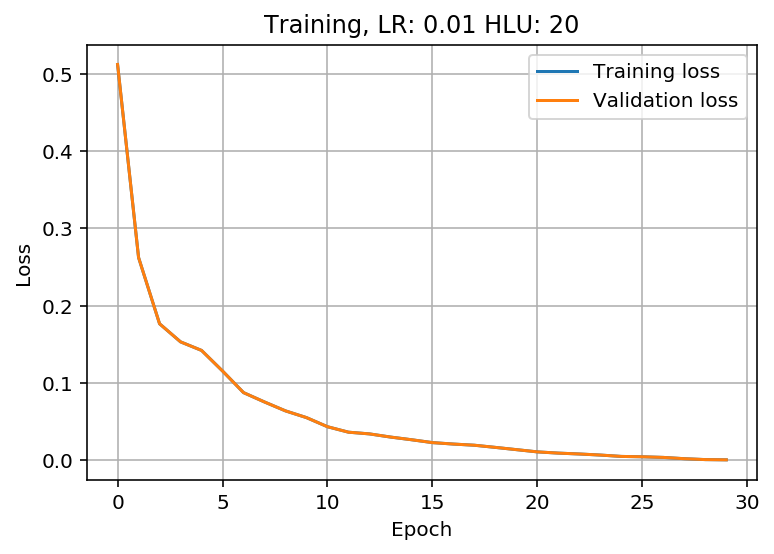

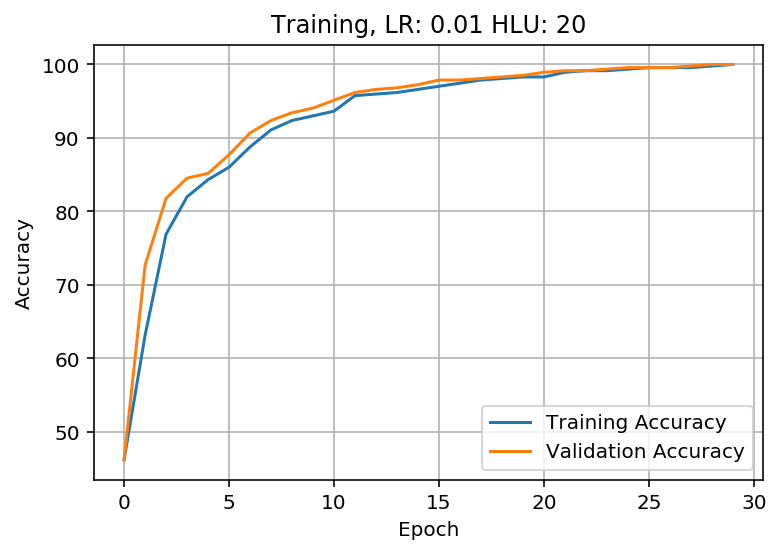

In [20]:
nnetEffLN.visualise_training()

#### Predict sentiment of unseen data

In [21]:
nnetEffLN.predict("Although i told u dat i'm into baig face watches now but i really like e watch u gave cos it's fr u. Thanx 4 everything dat u've done today, i'm touched...")

array([  2.49670061e-14])

In [22]:
nnetEffLN.predict("SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575.")

array([ 0.00248228])

#### If satisfied with the results, update our training data over time. We will use this for analysis later.

In [23]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [24]:
def save_confusion_matrix_to_csv(df, csvFilePath, sep=","):
    if not os.path.isfile(csvFilePath):
        df.to_csv(csvFilePath, mode='a', index=False, sep=sep)
    else:
        df.to_csv(csvFilePath, mode='a', index=False, sep=sep, header=False)

In [103]:
# update training data to disk
csv_train_filepath = "training/spam_cf_matrix_lr.csv"
ensure_dir(csv_train_filepath)
df = nnetEffLN.get_confusion_matrix()
save_confusion_matrix_to_csv(df, csv_train_filepath)

Show training data and progress

In [104]:
# load our saved data
csv_train_filepath = "training/spam_cf_matrix_lr.csv"
training_metrics = pd.read_csv(csv_train_filepath, encoding='latin-1')

In [105]:
# Show first 10 results
training_metrics.tail(10)

,EP,LR,HLU,TP,FP,TN,FN,RECALL,PRECISION,F1-S,MCC-S,TE-ACC,TR-ACC,VA-ACC
0,20,0.01,100,51.0,18.0,506.0,25.0,67.105263,73.913043,70.344828,70.344828,92.833333,95.127119,95.974576


### Data Analysis

##### Listing of short codes


- EP: No. of Epochs  
- LR: Learning Rate
- HLU: No. of Hiddel Layer Units
- TP: True Positive
- FP - False Positive
- TN: - True Negative
- FN: - False Negative
- F1-S : - F1-Score
- MCC-S: - Matthews Correlation Coefficient
- TE-ACC: Testing Accuracy for last Epoch
- TR-ACC: Training Accuracy for last Epoch
- VA-ACC: Validation Accuracy for last Epoch

##### Tabulation of training results for different hyper-parameters.

In [106]:
# Image(filename='training/tables/results_final.png')

### Saved trained Model

In [107]:
# save the model to disk
model_trained_filepath = 'models/spam_model_lr0.01epoch_25hlu_10.sav'
ensure_dir(model_trained_filepath)
cPickle.dump(nnetEffLN, open(model_trained_filepath, 'wb'))

### Load trained Model

In [108]:
# load the model from disk
model_trained_filepath = 'models/spam_model_lr0.01epoch_25hlu_10.sav'
loaded_model = cPickle.load(open(model_trained_filepath, 'rb'))

#### Predict sentiment of unseen data

Ensure that the results for loaded model are same as for the pre-saved model

In [109]:
loaded_model.predict("Although i told u dat i'm into baig face watches now but i really like e watch u gave cos it's fr u. Thanx 4 everything dat u've done today, i'm touched...")

array([  1.43288435e-32])

In [110]:
loaded_model.predict("SIX chances to win CASH! From 100 to 20,000 pounds txt")

array([  2.15002213e-06])

In [111]:
loaded_model.predict("Thanks for your subscription to Ringtone UK your mobile will be charged å£5/month Please confirm by replying YES or NO. If you reply NO you will not be charged")

array([ 1.])

### Deploy saved trained Model

At this point the model can be deployed and distributed as a service. It can be deployed as a web application, mobile app, smart personal asistants such as `Google Now`,`Google Home`, `Amazon Echo` e.t.c.